In this notebook, I explore the potential of predicting snow depth over MCS using established distribution pattern and sparse point measurements (At most 10)

In [9]:
import os
import rasterio
import xarray as xr
import rioxarray as rxr
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import rasterstats as rs
from rasterstats import point_query
import numpy as np
from datetime import datetime
from metloom.pointdata import SnotelPointData
import pytz
import pandas as pd
import geopandas as gpd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from scipy.stats import pearsonr
# Set the font size and style
plt.rcParams.update({'font.size': 16, 'font.family': 'Helvetica'})

## The distribution Pattern
The distribution pattern has been established from a temporal average of the standardized depth value for all available LiDAR data. The pattern and the snow depth rasters from which they are derived plotted below. The locations of the 10 points are shown on the distribution pattern as black points

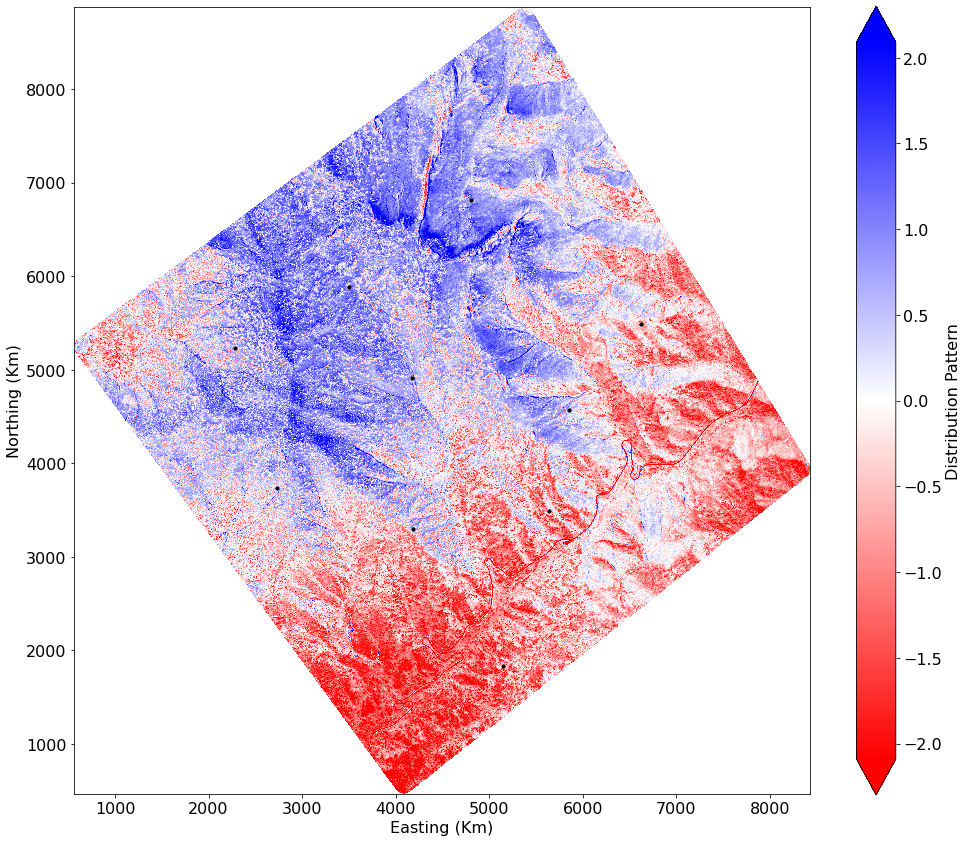

In [5]:
gdf = gpd.read_file('/home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/results/Training_Points_10.gpkg')
sdv_raster = rxr.open_rasterio('/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/sdv/sdv_average.tif', masked = True)
fig, ax = plt.subplots( figsize=(14, 12))
im = sdv_raster.plot(ax=ax, cmap= 'bwr_r', robust = True, cbar_kwargs={'label': 'Distribution Pattern'})
gdf.plot(ax=ax, markersize=10, color='black')
ax.set_title('')
ax.set_aspect('equal')
ax.set_xlabel('Easting (Km)')
ax.set_ylabel('Northing (Km)')
# Format x and y-axis labels to subtract leading digits
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x - 4.862e6)}"))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x - 601000)}"))
plt.tight_layout()
plt.show()

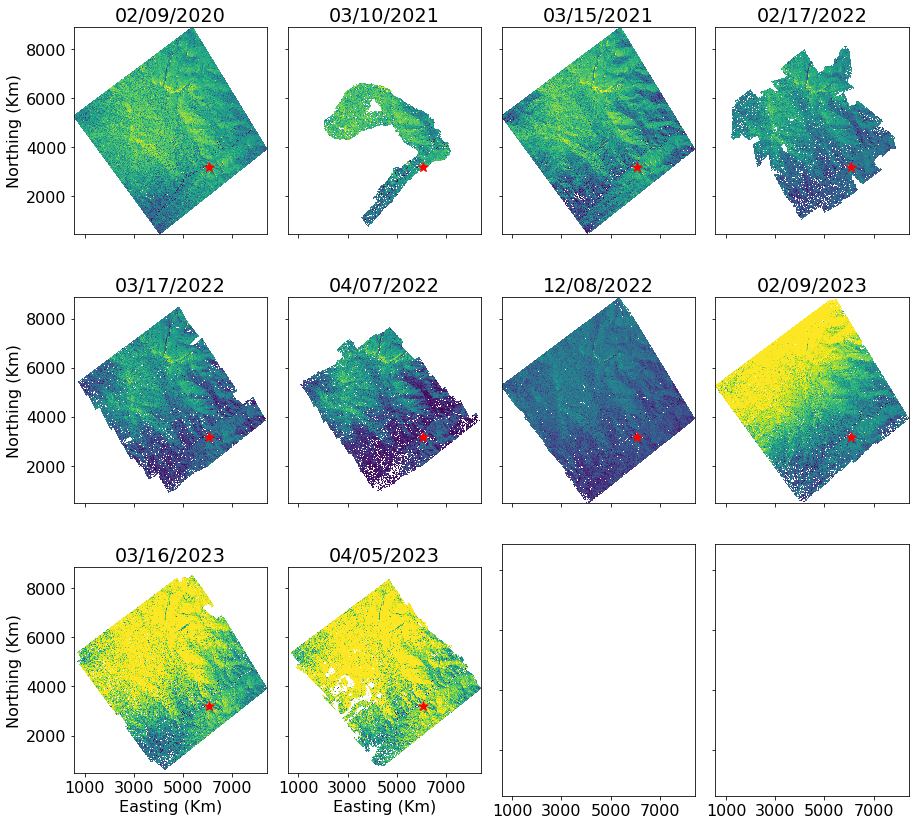

In [6]:
Dates = ["02/09/2020", "03/10/2021","03/15/2021", "02/17/2022", "03/17/2022", "04/07/2022", "12/08/2022", "02/09/2023", "03/16/2023", "04/05/2023"]

#snow depth --> The unfiltered snow depth rasters
sd_files = ['/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/lidar-snowdepth/QSI_0.5M_PCSD_USIDMC_20200209_20200209.tif',
            '/SNOWDATA/IDALS/2021/20210310_MCS/ice-road/20210310_MCS-snowdepth.tif',
            '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/lidar-snowdepth/QSI_0.5M_PCSD_USIDMC_20210315_20210315.tif',
            '/SNOWDATA/IDALS/2022/20220217_MCS/ice-road/20220217_MCS-snowdepth.tif',
            '/SNOWDATA/IDALS/2022/20220317_MCS/ice-road/20220317_MCS-snowdepth.tif',
            '/SNOWDATA/IDALS/2022/20220407_MCS/ice-road/20220407_MCS-snowdepth.tif',
            '/SNOWDATA/IDALS/2023/20221208_MCS/ice-road/20221208_MCS-snowdepth.tif',
            '/SNOWDATA/IDALS/2023/20230209_MCS/ice-road/20230209_MCS-snowdepth.tif',
            '/SNOWDATA/IDALS/2023/20230316_MCS/ice-road/20230316_MCS-snowdepth.tif',
            '/SNOWDATA/IDALS/2023/hanover_reprocess_20230405/ice-road/hanover_reprocess-snowdepth.tif']
#snow depth --> The filtered snow depth rasters ( 0 < sd < [mean + 5standard deviation]) : The post-processing notebook can be found here /home/naheemadebisi/nfs_home/snow-analytics/lidar_mcs/scripts/post_process.ipynb
sdf_files = ['/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/QSI_0.5M_PCSD_USIDMC_20200209_20200209.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20210310_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/QSI_0.5M_PCSD_USIDMC_20210315_20210315.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20220217_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20220317_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20220407_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20221208_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20230209_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20230316_MCS-snowdepth.tif',
                     '/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/hanover_reprocess-snowdepth.tif']

# Set minimum and maximum values for colormap  
vmin = 0
vmax = 3
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(13, 12), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    if i < len(sdf_files):
        snow_depth = rxr.open_rasterio(sdf_files[i], masked=True)
        im = snow_depth.plot(ax=ax, cmap='viridis', vmin=vmin, vmax=vmax, add_colorbar=False, robust=True)
        ax.scatter(607084.3493239387, 4865185.334007569, marker='*', s=100, color="red", label='SNOTEL')
        ax.set_title(Dates[i])
        ax.set_aspect('equal')
        ax.set_xlabel('Easting (Km)')
        ax.set_ylabel('Northing (Km)')
        ax.label_outer()  # Hides the labels of the shared axes
        # Format x and y-axis labels to subtract leading digits
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x - 4.862e6)}"))
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{int(x - 601000)}"))
        


plt.tight_layout()
plt.show()


## Predicting with the Distribution Pattern

Here I want to use few point measurement (at most 10) and the distribution pattern to predict snow depth. 

In [7]:

#read the sdv raster values
sdv_values = sdv_raster.values.flatten()
for i in range(len(sdf_files)):
    #sample the sdv and snow depth at 10 points
    snowDepth = rxr.open_rasterio(sdf_files[i])
    sdv = point_query(gdf.geometry, sdv_raster.squeeze().values, affine = snowDepth.rio.transform(), nodata = -9999)
    sd = point_query(gdf.geometry, snowDepth.squeeze().values, affine = snowDepth.rio.transform(), nodata = -9999)
    df = pd.DataFrame({'sdv': sdv, 'sd' : sd})
    # Preparing the data for regression
    df = df.dropna()
    num_records = len(df)
    X = df['sdv'].values.reshape(-1, 1)  # Predictor variable
    y = df['sd'].values  # Response variable

    # Performing linear regression
    regression_model = LinearRegression()
    regression_model.fit(X, y)

    # Extracting the slope (coefficient) and intercept
    slope = regression_model.coef_[0]
    intercept = regression_model.intercept_

    # sample sdv raster for easy prediction
    data = pd.DataFrame({'sdv': sdv_values})
    #predicting
    data['sd_predict'] = (data['sdv'] * slope) + intercept
    #get the truth data
    sd_values =  rxr.open_rasterio(sdf_files[i], masked = True).values.flatten() #the snow depth raster
    data['sd'] = sd_values
    # all data assessment
    data_all = data[['sd', 'sd_predict']].dropna()
    r = data_all['sd'].corr(data_all['sd_predict'])
    rmse = np.sqrt(mean_squared_error(data_all['sd'], data_all['sd_predict']))
    r, rmse

    print(f'{Dates[i]}: The r and rmse are { r, rmse}. The data is trained with { len(df)} points')

    # Convert sd column back to original raster shape
    sd_predict_raster = sdv_raster.copy(data=data['sd_predict'].values.reshape(sdv_raster.shape))
    path = sdf_files[i]
    filename_without_extension = os.path.splitext(os.path.basename(path))[0] # Get the filename without the extension
    new_filename = filename_without_extension + '_10pts_predict.tif'  # Append "_10pts_predict.tif" to the filename
    new_path = os.path.join(os.path.dirname(path), new_filename) # The new path with the modified filename
    sd_predict_raster.rio.to_raster(new_path) # Write out raster

02/09/2020: The r and rmse are (0.8864236321224411, 0.20423897155595358). The data is trained with 10 points
03/10/2021: The r and rmse are (0.9379345607196841, 0.18550149769344448). The data is trained with 4 points
03/15/2021: The r and rmse are (0.9316626993002884, 0.19435708436171364). The data is trained with 10 points
02/17/2022: The r and rmse are (0.9632240467287679, 0.1582874794812072). The data is trained with 7 points
03/17/2022: The r and rmse are (0.9585405810479117, 0.15493635006287296). The data is trained with 10 points
04/07/2022: The r and rmse are (0.9185979204147172, 0.28320163203843735). The data is trained with 8 points
12/08/2022: The r and rmse are (0.9262913016530177, 0.14692908896167373). The data is trained with 10 points
02/09/2023: The r and rmse are (0.8345701793238616, 0.5029157651810426). The data is trained with 10 points
03/16/2023: The r and rmse are (0.968021884004958, 0.19419943361290887). The data is trained with 9 points
04/05/2023: The r and rmse

## Assess the predicted snow depth using LiDAR snow depth.

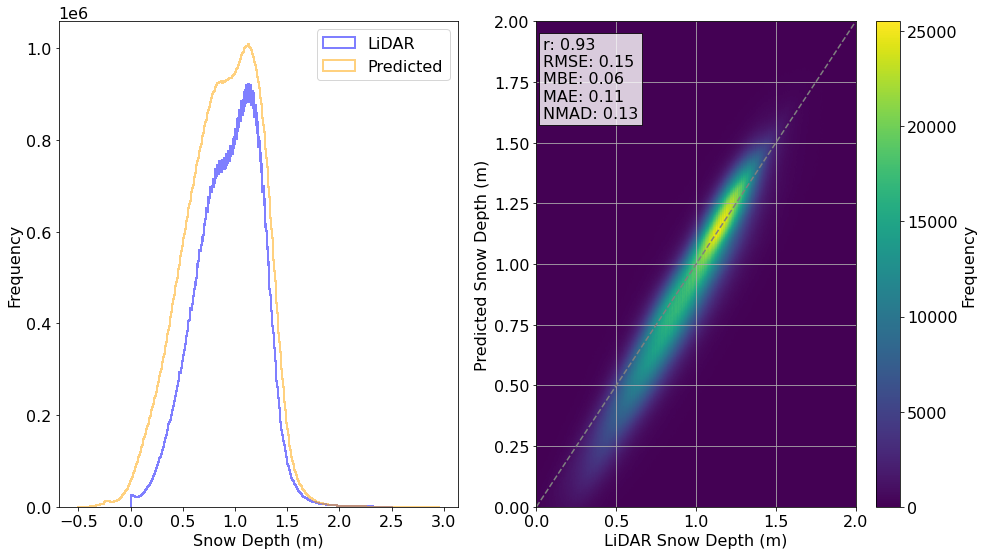

In [10]:
pred = rxr.open_rasterio('/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20221208_MCS-snowdepth_10pts_predict.tif')
Lid = rxr.open_rasterio('/nfs_home/naheemadebisi/snow-analytics/lidar_mcs/results/snowdepth/filtered/20221208_MCS-snowdepth.tif')
LiD_values = Lid.values.flatten()
pred_values = pred.values.flatten()
valid_indices = ~np.isnan(LiD_values) & ~np.isnan(pred_values)
LiD_values = LiD_values[valid_indices]
pred_values = pred_values[valid_indices]
# Create a single figure with two subplots (histogram and heatmap)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))

# Plot histogram of LiDAR and predicted snow depth distributions
axes[0].hist(LiD_values, bins=500, color='blue', alpha=0.5, histtype='step', linewidth=2, label='LiDAR')
axes[0].hist(pred_values, bins=500, color='orange', alpha=0.5, histtype='step', linewidth=2, label='Predicted')
axes[0].set_xlabel('Snow Depth (m)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Create a heatmap to compare LiDAR and predicted snow depth
heatmap, xedges, yedges = np.histogram2d(LiD_values, pred_values, bins=500)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
im = axes[1].imshow(heatmap.T, origin='lower', extent=extent, cmap='viridis', aspect='auto')

# Add a hypothetical one-to-one dashed line
axes[1].plot([0, 2], [0, 2], linestyle='--', color='gray')

# Calculate the correlation coefficient
correlation, _ = pearsonr(LiD_values, pred_values)
correlation_text = f'r: {correlation:.2f}'

# Calculate the Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(LiD_values, pred_values))
rmse_text = f'RMSE: {rmse:.2f}'

# Calculate MBE, MAE, and NMAD
mbe = np.mean(LiD_values - pred_values)
mbe_text = f'MBE: {mbe:.2f}'
mae = np.mean(np.abs(LiD_values - pred_values))
mae_text = f'MAE: {mae:.2f}'
nmad = 1.4826 * np.median(np.abs(LiD_values - pred_values))
nmad_text = f'NMAD: {nmad:.2f}'

# Add the correlation coefficient and RMSE as text to the upper left corner
combined_text = '\n'.join([correlation_text, rmse_text, mbe_text, mae_text, nmad_text])
axes[1].text(0.02, 0.80, combined_text, transform=axes[1].transAxes, color='black', bbox=dict(facecolor='white', alpha=0.8))

# Add colorbar to the heatmap
cbar = plt.colorbar(im, ax=axes[1], label='Frequency')
axes[1].set_xlabel('LiDAR Snow Depth (m)')
axes[1].set_ylabel('Predicted Snow Depth (m)')
axes[1].set_xlim(0, 2)
axes[1].set_ylim(0, 2)
axes[1].grid(True)

# Adjust layout and show the figure
plt.tight_layout()
plt.show()